In [1]:
import numpy as np
import pandas as pd
# import sklearn
from sklearn.model_selection import train_test_split
import random
import keras
from keras import applications
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras.models import Model
from scipy import stats
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm.libsvm import cross_validation

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

#### non-binary group

In [5]:
# # load data
x_train = np.load("data/transfer_learning_train_aligned.txt.npz")
y_train = np.load("data/transfer_learning_gender_label_train_aligned.txt.npz")
x_val = np.load("data/transfer_learning_val_aligned.txt.npz")
y_val = np.load("data/transfer_learning_gender_label_val_aligned.txt.npz")
x_test = np.load("data/transfer_learning_test_aligned.txt.npz")
y_test = np.load("data/transfer_learning_gender_label_test_aligned.txt.npz")
x_nonBinary = np.load("data/non_binary_x.txt.npz")
y_nonBinary = np.load("data/non_binary_gender.txt.npz")

x_nonBinary = np.load("data/non_binary_x_aligned.txt.npz")
y_nonBinary = np.load("data/non_binary_gender_aligned.txt.npz")


# x_nonBinary_augmented = np.load("data/non_binary_augmented_x.txt.npz")
# y_nonBinary_augmented = np.load("data/non_binary_augmented_y.txt.npz")

In [6]:
# # load data
# x_train = np.load("data/transfer_learning_train.txt.npz")
# y_train = np.load("data/transfer_learning_gender_label_train.txt.npz")
# x_val = np.load("data/transfer_learning_val.txt.npz")
# y_val = np.load("data/transfer_learning_gender_label_val.txt.npz")
# x_test = np.load("data/transfer_learning_test.txt.npz")
# y_test = np.load("data/transfer_learning_gender_label_test.txt.npz")
# x_nonBinary = np.load("data/non_binary_x.txt.npz")
# y_nonBinary = np.load("data/non_binary_gender.txt.npz")

In [7]:
# data pre-processing
image_size = 2102
# image_size = 2038
image_size_augmented = 3057

#train
x_train = x_train['a'].reshape(6000, 227, 227, 3)
gender_train = y_train['a']
y_train = y_train['a'].reshape(6000, )
y_train = to_categorical(y_train)

#val
x_val = x_val['a'].reshape(3000, 227, 227, 3)
gender_val = y_val['a']
y_val = y_val['a'].reshape(3000, )
y_val = to_categorical(y_val)

#test
x_test = x_test['a'].reshape(3000, 227, 227, 3)
gender_test = y_test['a']
y_test = y_test['a'].reshape(3000, )
y_test = to_categorical(y_test)

#nonBinary
x_nonBinary = x_nonBinary['a'].reshape(image_size, 227, 227, 3)
gender_nonBinary = y_nonBinary['a']
y_nonBinary = y_nonBinary['a'].reshape(image_size, )
y_nonBinary = to_categorical(y_nonBinary)

#nonBinaryAugmented
# x_nonBinary_augmented = x_nonBinary_augmented['a'].reshape(image_size_augmented, 227, 227, 3)
# gender_nonBinary_augmented = y_nonBinary_augmented['a']
# y_nonBinary_augmented = y_nonBinary_augmented['a'].reshape(image_size_augmented, )
# y_nonBinary_augmented = to_categorical(y_nonBinary_augmented)

In [8]:
#shuffle data
indices = np.arange(len(x_nonBinary))
np.random.seed(888)
np.random.shuffle(indices)
x_nonBinary = x_nonBinary[indices]
y_nonBinary = y_nonBinary[indices]
gender_nonBinary = gender_nonBinary[indices]

In [9]:
#shuffle data augmented
# indices = np.arange(len(x_nonBinary_augmented))
# np.random.seed(888)
# np.random.shuffle(indices)
# x_nonBinary_augmented = x_nonBinary_augmented[indices]
# y_nonBinary_augmented = y_nonBinary_augmented[indices]

In [10]:
#split train and test
x_nonB_train, x_nonB_test, gender_nonB_train, gender_nonB_test, y_nonB_train, y_nonB_test = train_test_split(x_nonBinary, gender_nonBinary, y_nonBinary, test_size=0.25, random_state=42)
#split train and val
x_nonB_train, x_nonB_val, gender_nonB_train, gender_nonB_val, y_nonB_train, y_nonB_val = train_test_split(x_nonB_train, 
gender_nonB_train, y_nonB_train, test_size=0.333, random_state=42)

In [11]:
# #split train and test augmented
# x_nonB_train_augmented, x_nonB_test_augmented, gender_nonB_train_augmented, gender_nonB_test_augmented, y_nonB_train_augmented, y_nonB_test_augmented = train_test_split(x_nonBinary_augmented, gender_nonBinary_augmented, y_nonBinary_augmented, test_size=0.25, random_state=42)
# #split train and val augmented
# x_nonB_train_augmented, x_nonB_val_augmented, gender_nonB_train_augmented, gender_nonB_val_augmented, y_nonB_train_augmented, y_nonB_val_augmented = train_test_split(x_nonB_train_augmented, 
# gender_nonB_train_augmented, y_nonB_train_augmented, test_size=0.333, random_state=42)

In [12]:
print("shape of train set is:", x_train.shape)
print("shape of val set is:", x_val.shape)
print("shape of nonbinary set is:", x_nonBinary.shape)
print("shape of train set in nonbinary  is:", x_nonB_train.shape)
print("shape of val set in nonbinary  is:", x_nonB_val.shape)
print("shape of test set in nonbinary  is:", x_nonB_test.shape)
# print("shape of train set in nonbinary augmented is:", x_nonB_train_augmented.shape)
# print("shape of val set in nonbinary augmented is:", x_nonB_val_augmented.shape)
# print("shape of test set in nonbinary augmented is:", x_nonB_test_augmented.shape)

shape of train set is: (6000, 227, 227, 3)
shape of val set is: (3000, 227, 227, 3)
shape of nonbinary set is: (2102, 227, 227, 3)
shape of train set in nonbinary  is: (1051, 227, 227, 3)
shape of val set in nonbinary  is: (525, 227, 227, 3)
shape of test set in nonbinary  is: (526, 227, 227, 3)


#### non-LGBTQ group

In [13]:
# x_nonLGBTQ = np.load("data/transfer_learning_test_aligned.txt.npz")
# y_nonLGBTQ = np.load("data/transfer_learning_gender_label_test_aligned.txt.npz")

x_nonLGBTQ = np.load("data/transfer_learning_test.txt.npz")
y_nonLGBTQ = np.load("data/transfer_learning_gender_label_test.txt.npz")

In [14]:
x_nonLGBTQ = x_nonLGBTQ['a'].reshape(3000, 227, 227, 3)
gender_nonLGBTQ_train = y_nonLGBTQ['a']
y_nonLGBTQ = y_nonLGBTQ['a'].reshape(3000, )
y_nonLGBTQ = to_categorical(y_nonLGBTQ)

In [15]:
#shuffle data
indices = np.arange(len(y_nonLGBTQ))
np.random.seed(888)
np.random.shuffle(indices)
x_nonLGBTQ = x_nonLGBTQ[indices]
y_nonLGBTQ = y_nonLGBTQ[indices]
#split train and test of non-lgbtq
x_nonLGBTQ_train, x_nonLGBTQ_test, y_nonLGBTQ_train, y_nonLGBTQ_test = train_test_split(x_nonLGBTQ, y_nonLGBTQ, test_size=0.25, random_state=42)
#split train and val of non-lgbtq
x_nonLGBTQ_train, x_nonLGBTQ_val, y_nonLGBTQ_train, y_nonLGBTQ_val = train_test_split(x_nonLGBTQ_train, y_nonLGBTQ_train, test_size=0.333, random_state=42)

In [16]:
print("shape of nonLGBTQ training set is:", y_nonLGBTQ_train.shape)
print("shape of nonLGBTQ val set is:", y_nonLGBTQ_val.shape)
print("shape of nonLGBTQ test set is:", y_nonLGBTQ_test.shape)

shape of nonLGBTQ training set is: (1500, 2)
shape of nonLGBTQ val set is: (750, 2)
shape of nonLGBTQ test set is: (750, 2)


In [17]:
new_class = np.zeros([1500, 1])
y_nonLGBTQ_train_new = np.hstack((y_nonLGBTQ_train, new_class))
new_class = np.zeros([750, 1])
y_nonLGBTQ_val_new = np.hstack((y_nonLGBTQ_val, new_class))
new_class = np.zeros([750, 1])
y_nonLGBTQ_test_new = np.hstack((y_nonLGBTQ_test, new_class))

#### LGBTQ group

In [18]:
x_lgbtq = np.load("data/lgbtq_x.txt.npz")
y_lgbtq = np.load("data/lgbtq_gender.txt.npz")
x_lgbtq = x_lgbtq['a'].reshape(2026, 227, 227, 3)
y_lgbtq = y_lgbtq['a'].reshape(2026, )
y_lgbtq = to_categorical(y_lgbtq)
print("shape of lgbtq set is:", y_lgbtq.shape)
# x_lgb['a'].shape

shape of lgbtq set is: (2026, 2)


In [19]:
#shuffle data
indices = np.arange(len(y_lgbtq))
np.random.seed(888)
np.random.shuffle(indices)
x_lgbtq = x_lgbtq[indices]
y_lgbtq = y_lgbtq[indices]
#split train and test of non-lgbtq
x_lgbtq_train, x_lgbtq_test, y_lgbtq_train, y_lgbtq_test = train_test_split(x_lgbtq, y_lgbtq, test_size=0.25, random_state=42)
#split train and val of non-lgbtq
x_lgbtq_train, x_lgbtq_val, y_lgbtq_train, y_lgbtq_val = train_test_split(x_lgbtq_train, y_lgbtq_train, test_size=0.333, random_state=42)

In [20]:
print("shape of lgbtq traing set is:", y_lgbtq_train.shape)
print("shape of lgbtq val set is:", y_lgbtq_val.shape)
print("shape of lgbtq test set is:", y_lgbtq_test.shape)

shape of lgbtq traing set is: (1013, 2)
shape of lgbtq val set is: (506, 2)
shape of lgbtq test set is: (507, 2)


In [21]:
new_class = np.zeros([1013, 1])
y_lgbtq_train_new = np.hstack((y_lgbtq_train, new_class))
new_class = np.zeros([506, 1])
y_lgbtq_val_new = np.hstack((y_lgbtq_val, new_class))
new_class = np.zeros([507, 1])
y_lgbtq_test_new = np.hstack((y_lgbtq_test, new_class))

In [22]:
x_comb_test = np.concatenate((x_nonB_test, x_nonLGBTQ_test))
y_comb_test = np.concatenate((y_nonB_test, y_nonLGBTQ_test_new))

### Augmented LGBTQ group

In [23]:
image_size_augmented = 6078
x_lgbtq_augmented = np.load("data/lgbtq_augmented_x.txt.npz")
x_lgbtq_augmented = x_lgbtq_augmented['a'].reshape(image_size_augmented, 227, 227, 3)
y_lgbtq_augmented = np.load("data/lgbtq_augmented_y.txt.npz")
gender_lgbtq_augmented = y_lgbtq_augmented['a']
y_lgbtq_augmented = y_lgbtq_augmented['a'].reshape(image_size_augmented, 2)

In [24]:
new_class = np.zeros([6078, 1])
y_lgbtq_augmented = np.hstack((y_lgbtq_augmented, new_class))

In [25]:
#shuffle augmented non binary data
indices = np.arange(len(x_lgbtq_augmented))
np.random.seed(888)
np.random.shuffle(indices)
x_lgbtq_augmented = x_lgbtq_augmented[indices]
y_lgbtq_augmented = y_lgbtq_augmented[indices]
gender_lgbtq_augmented = gender_lgbtq_augmented[indices]

#split augmented non-binary train and test
x_lgbtq_train_augmented, x_lgbtq_test_augmented, gender_lgbtq_train_augmented, gender_lgbtq_test_augmented, y_lgbtq_train_augmented, y_lgbtq_test_augmented = train_test_split(x_lgbtq_augmented, gender_lgbtq_augmented, y_lgbtq_augmented, test_size=0.25, random_state=42)

#split augmented non-binary train and val
x_lgbtq_train_augmented, x_lgbtq_val_augmented, gender_lgbtq_train_augmented, gender_lgbtq_val_augmented, y_lgbtq_train_augmented, y_lgbtq_val_augmented = train_test_split(x_lgbtq_train_augmented, gender_lgbtq_train_augmented, y_lgbtq_train_augmented, test_size=0.333, random_state=42)

print("shape of nonbinary set is:", x_lgbtq_augmented.shape)
print("shape of train set in lgbtq augmented is:", x_lgbtq_train_augmented.shape)
print("shape of val set in lgbtq augmented is:", x_lgbtq_val_augmented.shape)
print("shape of test set in lgbtq augmented is:", x_lgbtq_test_augmented.shape)

shape of nonbinary set is: (6078, 227, 227, 3)
shape of train set in lgbtq augmented is: (3040, 227, 227, 3)
shape of val set in lgbtq augmented is: (1518, 227, 227, 3)
shape of test set in lgbtq augmented is: (1520, 227, 227, 3)


### useful functions

In [26]:
#accuracy function
def evaluate_accuracy(baseline, x_test, y_test):
    test_accuracy = baseline.evaluate(x_test, y_test, verbose = 1, batch_size = 64)[1]
    return test_accuracy

In [27]:
def plot_confusion_matrix(df, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.matshow(df, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df.columns))
    plt.xticks(tick_marks, df.columns, rotation=45)
    plt.yticks(tick_marks, df.index)
    #plt.tight_layout()
    plt.ylabel(df.index.name)
    plt.xlabel(df.columns.name)
    
#     print(df)
    
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            plt.text(i, j, round(df[i][j], 4), fontsize=8, verticalalignment='center')

In [28]:
def generate_confusion_matrix(model, x_test_, y_test_):
    
    feat_out = get_feature_layer(cnn_model, x_test_)
    dtest = xgboost.DMatrix(feat_out)
    
    
    y_prob = model.predict(dtest)
#     print(y_prob)
    y_pred = pd.Series(y_prob, name='Predict')
    y_actu = pd.Series(np.argmax(y_test_, axis=1),  name='Actual')
    
    df_confusion = pd.crosstab(y_actu, y_pred)
    df_conf_norm = df_confusion.astype('float') / df_confusion.sum(axis=1)[:, np.newaxis]
    
    plot_confusion_matrix(df_conf_norm)

### x_comb_train, x_comb_val

In [29]:
x_comb_train = np.concatenate((x_nonLGBTQ_train, x_nonB_train))
y_comb_train = np.concatenate((y_nonLGBTQ_train_new, y_nonB_train))

In [30]:
x_comb_val = np.concatenate((x_nonLGBTQ_val, x_nonB_val))
y_comb_val = np.concatenate((y_nonLGBTQ_val_new, y_nonB_val))

In [31]:
print("shape of nonLGBTQ traing set is:", x_nonLGBTQ_train.shape)
print("shape of LGBTQ training set is:", x_lgbtq_train.shape)
print("shape of nonBinary training set is:", x_nonB_train.shape)

shape of nonLGBTQ traing set is: (1500, 227, 227, 3)
shape of LGBTQ training set is: (1013, 227, 227, 3)
shape of nonBinary training set is: (1051, 227, 227, 3)


In [32]:
print("shape of nonLGBTQ val set is:", x_nonLGBTQ_val.shape)
print("shape of LGBTQ val set is:", x_lgbtq_val.shape)
print("shape of nonBinary val set is:", x_nonB_val.shape)

shape of nonLGBTQ val set is: (750, 227, 227, 3)
shape of LGBTQ val set is: (506, 227, 227, 3)
shape of nonBinary val set is: (525, 227, 227, 3)


In [33]:
x_comb_train.shape

(2551, 227, 227, 3)

### Oversampling

In [ ]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

x_comb_train = x_comb_train.reshape(2551, 154587)
sm = SMOTE(random_state=42, ratio='minority')
x_comb_train_oversampled, y_comb_train_oversampled = sm.fit_sample(x_comb_train, y_comb_train)

In [ ]:
x_comb_train_oversampled = x_comb_train_oversampled.reshape(2855, 227, 227, 3)

### x_comb_train_equal, x_comb_val_equal

In [49]:
x_comb_train_equal = np.concatenate((x_nonLGBTQ_train[:1000], x_nonB_train[:1000], x_lgbtq_train[:1000]))
y_comb_train_equal = np.concatenate((y_nonLGBTQ_train_new[:1000], y_nonB_train[:1000], y_lgbtq_train_new[:1000]))

x_comb_val_equal = np.concatenate((x_nonLGBTQ_val[:500], x_nonB_val[:500], x_lgbtq_val[:500]))
y_comb_val_equal = np.concatenate((y_nonLGBTQ_val_new[:500], y_nonB_val[:500], y_lgbtq_val_new[:500]))

In [50]:
print("shape of nonLGBTQ traing set is:", x_nonLGBTQ_train[:1000].shape)
print("shape of LGBTQ training set is:", x_lgbtq_train[:1000].shape)
print("shape of nonBinary training set is:", x_nonB_train[:1000].shape)

shape of nonLGBTQ traing set is: (1000, 227, 227, 3)
shape of LGBTQ training set is: (1000, 227, 227, 3)
shape of nonBinary training set is: (1000, 227, 227, 3)


In [51]:
print("shape of nonLGBTQ val set is:", x_lgbtq_val[:500].shape)
print("shape of LGBTQ val set is:", x_nonLGBTQ_val[:500].shape)
print("shape of nonBinary val set is:", x_nonB_val[:500].shape)

shape of nonLGBTQ val set is: (500, 227, 227, 3)
shape of LGBTQ val set is: (500, 227, 227, 3)
shape of nonBinary val set is: (500, 227, 227, 3)


### x_comb_train_augmented, x_comb_val_augmented

In [33]:
x_comb_train_augmented = np.concatenate((x_nonLGBTQ_train, x_nonB_train_augmented, x_lgbtq_train))
y_comb_train_augmented = np.concatenate((y_nonLGBTQ_train_new, y_nonB_train_augmented, y_lgbtq_train_new))

x_comb_val_augmented = np.concatenate((x_nonLGBTQ_val, x_nonB_val_augmented, x_lgbtq_val))
y_comb_val_augmented = np.concatenate((y_nonLGBTQ_val_new, y_nonB_val_augmented, y_lgbtq_val_new))

In [48]:
print(x_nonLGBTQ_train.shape, x_nonB_train_augmented.shape, x_lgbtq_train.shape)
print(x_nonLGBTQ_val.shape, x_nonB_val_augmented.shape, x_lgbtq_val.shape)

(1500, 227, 227, 3) (3058, 227, 227, 3) (1013, 227, 227, 3)
(750, 227, 227, 3) (1527, 227, 227, 3) (506, 227, 227, 3)


In [34]:
print("shape of augmented traing set is:", x_comb_train_augmented.shape)
print("shape of augmented val set is:", x_comb_val_augmented.shape)
print("shape of augmented test set is:", x_comb_test_augmented.shape)

shape of augmented traing set is: (5571, 227, 227, 3)
shape of augmented val set is: (2783, 227, 227, 3)
shape of augmented test set is: (2786, 227, 227, 3)


### x_comb_train_augmented_LGBTQ, y_comb_val_augmented

In [72]:
x_comb_train_augmented_lgbtq = np.concatenate((x_nonLGBTQ_train, x_nonB_train_augmented, x_lgbtq_train_augmented))
y_comb_train_augmented_lgbtq = np.concatenate((y_nonLGBTQ_train_new, y_nonB_train_augmented, y_lgbtq_train_augmented))

x_comb_val_augmented_lgbtq = np.concatenate((x_nonLGBTQ_val, x_nonB_val_augmented, x_lgbtq_val_augmented))
y_comb_val_augmented_lgbtq = np.concatenate((y_nonLGBTQ_val_new, y_nonB_val_augmented, y_lgbtq_val_augmented))

### load CNN model

In [45]:
# cnn_model = load_model('model/tansfer_learning_using_equal_data.h5')
# cnn_model = load_model('model/train_with_all.h5')
# cnn_model = load_model('model/tansfer_learning_using_augmented_data.h5')
# cnn_model = load_model('model/tansfer_learning_using_comb_data2_2_classes.h5')
# cnn_model = load_model('model/tansfer_learning_using_comb_data2_2_classes_oversampled.h5')
# cnn_model = load_model('model/tansfer_learning_using_unaligned_oversampled_data.h5')
cnn_model = load_model('model/tansfer_learning_vgg19_aligned_oversampled.h5')

In [46]:
def get_feature_layer(model, data):
    total_layers = len(model.layers)
    fl_index = total_layers - 1
    feature_layer_model = Model(inputs=model.input, outputs=model.get_layer(index=fl_index).output)
    feature_layer_output = feature_layer_model.predict(data)
    return feature_layer_output

In [47]:
def train_xgb_cnn(x_train_, y_train_, x_val_, y_val_, num_round=5000):
    param = {
        'eta': best_params_['learning_rate'],
        'max_depth': best_params_['max_depth'],
        'objective':'multi:softmax',
        'n_estimators': best_params_['n_estimators'],
        'min_child_weight': best_params_['min_child_weight'],
        'num_class':3
    }
    
    # A parameter grid for XGBoost
    param['eval_metric'] = ['merror']
#     param['eval_metric'] = ['mlogloss']
    
    feat_out = get_feature_layer(cnn_model, x_train_)
    print(feat_out.shape)
    dtrain = xgboost.DMatrix(feat_out, label=y_train_.argmax(axis=1))
    
    
    feat_out_val = get_feature_layer(cnn_model, x_val_)
    dval = xgboost.DMatrix(feat_out_val, label=y_val_.argmax(axis=1))
    watchlist = [(dtrain, 'train'), (dval, 'valid')]
    
    
    xgb_feature_layer = xgboost.train(param, dtrain, num_round, verbose_eval=1, 
                                      evals=watchlist, early_stopping_rounds=2000)
    
    y_pred = xgb_feature_layer.predict(dtrain)
    y_true = y_train_.argmax(axis=1)
    train_acc = accuracy_score(y_true, y_pred)
    print('trained round: {} and training accuracy: {}'.format(num_round, train_acc))
    return xgb_feature_layer

In [48]:
def eval_xgb_acc(model, x_test_, y_test_):
    feat_out = get_feature_layer(cnn_model, x_test_)
    
    dtest = xgboost.DMatrix(feat_out)
#     print(dtest)
    y_pred = model.predict(dtest)
    y_true = y_test_.argmax(axis=1)
    train_acc = accuracy_score(y_true, y_pred)
    print('test accuracy: {}'.format(train_acc))

In [49]:
xgb_model = XGBClassifier(objective='multi:softmax', silent=True, num_class=3, eval_metric='merror')
test_params = {
    'n_estimators': [100, 125, 150, 175],
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [2, 3, 4], 
    'min_child_weight': [1, 2, 3]
}
model = GridSearchCV(estimator = xgb_model, param_grid = test_params, cv=5)
x_cv = get_feature_layer(cnn_model, x_comb_train)
y_cv = y_comb_train.argmax(axis=1)
model.fit(x_cv, y_cv)
print(model.best_params_)

{'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}


In [50]:
best_params_ = model.best_params_

In [51]:
xgb_model = train_xgb_cnn(x_comb_train, y_comb_train, x_comb_val, y_comb_val)

(2551, 3)
[0]	train-merror:0.251666	valid-merror:0.374902
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 2000 rounds.
[1]	train-merror:0.251666	valid-merror:0.374902
[2]	train-merror:0.251666	valid-merror:0.374902
[3]	train-merror:0.251666	valid-merror:0.374902
[4]	train-merror:0.250098	valid-merror:0.375686
[5]	train-merror:0.254018	valid-merror:0.371765
[6]	train-merror:0.254018	valid-merror:0.371765
[7]	train-merror:0.254018	valid-merror:0.371765
[8]	train-merror:0.255586	valid-merror:0.37098
[9]	train-merror:0.255586	valid-merror:0.37098
[10]	train-merror:0.255586	valid-merror:0.371765
[11]	train-merror:0.255586	valid-merror:0.37098
[12]	train-merror:0.254802	valid-merror:0.373333
[13]	train-merror:0.254802	valid-merror:0.373333
[14]	train-merror:0.254802	valid-merror:0.373333
[15]	train-merror:0.254802	valid-merror:0.372549
[16]	train-merror:0.254802	valid-merror:0.373333
[17]	train-merror:0

[165]	train-merror:0.250098	valid-merror:0.372549
[166]	train-merror:0.250098	valid-merror:0.372549
[167]	train-merror:0.250098	valid-merror:0.372549
[168]	train-merror:0.250098	valid-merror:0.372549
[169]	train-merror:0.250098	valid-merror:0.372549
[170]	train-merror:0.250098	valid-merror:0.372549
[171]	train-merror:0.250098	valid-merror:0.372549
[172]	train-merror:0.250098	valid-merror:0.372549
[173]	train-merror:0.250098	valid-merror:0.372549
[174]	train-merror:0.250098	valid-merror:0.372549
[175]	train-merror:0.249706	valid-merror:0.372549
[176]	train-merror:0.249706	valid-merror:0.372549
[177]	train-merror:0.249706	valid-merror:0.372549
[178]	train-merror:0.249706	valid-merror:0.372549
[179]	train-merror:0.249706	valid-merror:0.372549
[180]	train-merror:0.249706	valid-merror:0.372549
[181]	train-merror:0.249706	valid-merror:0.372549
[182]	train-merror:0.249314	valid-merror:0.372549
[183]	train-merror:0.249314	valid-merror:0.372549
[184]	train-merror:0.249314	valid-merror:0.372549


[330]	train-merror:0.23481	valid-merror:0.374118
[331]	train-merror:0.23481	valid-merror:0.374118
[332]	train-merror:0.23481	valid-merror:0.374118
[333]	train-merror:0.23481	valid-merror:0.374118
[334]	train-merror:0.23481	valid-merror:0.374118
[335]	train-merror:0.23481	valid-merror:0.374118
[336]	train-merror:0.23481	valid-merror:0.374118
[337]	train-merror:0.23481	valid-merror:0.374118
[338]	train-merror:0.234026	valid-merror:0.374118
[339]	train-merror:0.234026	valid-merror:0.374118
[340]	train-merror:0.233634	valid-merror:0.374118
[341]	train-merror:0.233634	valid-merror:0.374118
[342]	train-merror:0.233634	valid-merror:0.374118
[343]	train-merror:0.233634	valid-merror:0.374118
[344]	train-merror:0.232458	valid-merror:0.373333
[345]	train-merror:0.233634	valid-merror:0.373333
[346]	train-merror:0.232066	valid-merror:0.372549
[347]	train-merror:0.231282	valid-merror:0.371765
[348]	train-merror:0.23089	valid-merror:0.371765
[349]	train-merror:0.230498	valid-merror:0.371765
[350]	tra

[495]	train-merror:0.22305	valid-merror:0.374118
[496]	train-merror:0.22305	valid-merror:0.374118
[497]	train-merror:0.22305	valid-merror:0.374902
[498]	train-merror:0.22305	valid-merror:0.374902
[499]	train-merror:0.22305	valid-merror:0.374902
[500]	train-merror:0.22305	valid-merror:0.374902
[501]	train-merror:0.22305	valid-merror:0.374902
[502]	train-merror:0.22305	valid-merror:0.374902
[503]	train-merror:0.223442	valid-merror:0.374118
[504]	train-merror:0.223442	valid-merror:0.373333
[505]	train-merror:0.223442	valid-merror:0.373333
[506]	train-merror:0.223442	valid-merror:0.372549
[507]	train-merror:0.223442	valid-merror:0.372549
[508]	train-merror:0.223442	valid-merror:0.372549
[509]	train-merror:0.223442	valid-merror:0.372549
[510]	train-merror:0.223442	valid-merror:0.372549
[511]	train-merror:0.223442	valid-merror:0.372549
[512]	train-merror:0.223442	valid-merror:0.372549
[513]	train-merror:0.223442	valid-merror:0.372549
[514]	train-merror:0.22305	valid-merror:0.372549
[515]	tra

[661]	train-merror:0.214034	valid-merror:0.370196
[662]	train-merror:0.214034	valid-merror:0.370196
[663]	train-merror:0.214034	valid-merror:0.370196
[664]	train-merror:0.214034	valid-merror:0.370196
[665]	train-merror:0.213642	valid-merror:0.370196
[666]	train-merror:0.213642	valid-merror:0.370196
[667]	train-merror:0.213642	valid-merror:0.370196
[668]	train-merror:0.213642	valid-merror:0.370196
[669]	train-merror:0.213642	valid-merror:0.370196
[670]	train-merror:0.213642	valid-merror:0.370196
[671]	train-merror:0.213642	valid-merror:0.370196
[672]	train-merror:0.212858	valid-merror:0.369412
[673]	train-merror:0.212858	valid-merror:0.369412
[674]	train-merror:0.212858	valid-merror:0.369412
[675]	train-merror:0.212858	valid-merror:0.369412
[676]	train-merror:0.212858	valid-merror:0.369412
[677]	train-merror:0.212858	valid-merror:0.369412
[678]	train-merror:0.212466	valid-merror:0.369412
[679]	train-merror:0.212074	valid-merror:0.369412
[680]	train-merror:0.212074	valid-merror:0.369412


[827]	train-merror:0.204234	valid-merror:0.372549
[828]	train-merror:0.204626	valid-merror:0.372549
[829]	train-merror:0.203842	valid-merror:0.372549
[830]	train-merror:0.203842	valid-merror:0.372549
[831]	train-merror:0.203842	valid-merror:0.372549
[832]	train-merror:0.203842	valid-merror:0.372549
[833]	train-merror:0.203842	valid-merror:0.372549
[834]	train-merror:0.203842	valid-merror:0.372549
[835]	train-merror:0.203842	valid-merror:0.372549
[836]	train-merror:0.203842	valid-merror:0.372549
[837]	train-merror:0.203842	valid-merror:0.372549
[838]	train-merror:0.203842	valid-merror:0.372549
[839]	train-merror:0.203842	valid-merror:0.372549
[840]	train-merror:0.203842	valid-merror:0.372549
[841]	train-merror:0.203842	valid-merror:0.373333
[842]	train-merror:0.203842	valid-merror:0.373333
[843]	train-merror:0.203842	valid-merror:0.373333
[844]	train-merror:0.203842	valid-merror:0.373333
[845]	train-merror:0.203842	valid-merror:0.373333
[846]	train-merror:0.203842	valid-merror:0.373333


[992]	train-merror:0.199922	valid-merror:0.374118
[993]	train-merror:0.199922	valid-merror:0.374118
[994]	train-merror:0.199922	valid-merror:0.374118
[995]	train-merror:0.199922	valid-merror:0.374118
[996]	train-merror:0.199922	valid-merror:0.374118
[997]	train-merror:0.199922	valid-merror:0.374118
[998]	train-merror:0.199922	valid-merror:0.374118
[999]	train-merror:0.199922	valid-merror:0.374118
[1000]	train-merror:0.199922	valid-merror:0.374118
[1001]	train-merror:0.199922	valid-merror:0.374118
[1002]	train-merror:0.199922	valid-merror:0.374118
[1003]	train-merror:0.199922	valid-merror:0.374118
[1004]	train-merror:0.199922	valid-merror:0.373333
[1005]	train-merror:0.199922	valid-merror:0.373333
[1006]	train-merror:0.199922	valid-merror:0.373333
[1007]	train-merror:0.199922	valid-merror:0.374118
[1008]	train-merror:0.199922	valid-merror:0.374118
[1009]	train-merror:0.199922	valid-merror:0.374118
[1010]	train-merror:0.199922	valid-merror:0.374118
[1011]	train-merror:0.199922	valid-merr

[1153]	train-merror:0.196002	valid-merror:0.374118
[1154]	train-merror:0.196002	valid-merror:0.374118
[1155]	train-merror:0.19561	valid-merror:0.374118
[1156]	train-merror:0.194826	valid-merror:0.374118
[1157]	train-merror:0.194826	valid-merror:0.374118
[1158]	train-merror:0.194826	valid-merror:0.374118
[1159]	train-merror:0.194826	valid-merror:0.374118
[1160]	train-merror:0.194826	valid-merror:0.374118
[1161]	train-merror:0.194826	valid-merror:0.374118
[1162]	train-merror:0.195218	valid-merror:0.374118
[1163]	train-merror:0.194826	valid-merror:0.374118
[1164]	train-merror:0.194826	valid-merror:0.374118
[1165]	train-merror:0.194826	valid-merror:0.374902
[1166]	train-merror:0.194826	valid-merror:0.374902
[1167]	train-merror:0.194826	valid-merror:0.374902
[1168]	train-merror:0.194826	valid-merror:0.374902
[1169]	train-merror:0.194826	valid-merror:0.374902
[1170]	train-merror:0.194826	valid-merror:0.374902
[1171]	train-merror:0.194434	valid-merror:0.374902
[1172]	train-merror:0.194434	val

[1314]	train-merror:0.190906	valid-merror:0.374902
[1315]	train-merror:0.190906	valid-merror:0.374902
[1316]	train-merror:0.190906	valid-merror:0.374902
[1317]	train-merror:0.190906	valid-merror:0.374902
[1318]	train-merror:0.190906	valid-merror:0.374902
[1319]	train-merror:0.190906	valid-merror:0.374902
[1320]	train-merror:0.190906	valid-merror:0.374902
[1321]	train-merror:0.190906	valid-merror:0.374902
[1322]	train-merror:0.190906	valid-merror:0.375686
[1323]	train-merror:0.190906	valid-merror:0.375686
[1324]	train-merror:0.190906	valid-merror:0.375686
[1325]	train-merror:0.190906	valid-merror:0.375686
[1326]	train-merror:0.190514	valid-merror:0.375686
[1327]	train-merror:0.190514	valid-merror:0.375686
[1328]	train-merror:0.190514	valid-merror:0.376471
[1329]	train-merror:0.190514	valid-merror:0.376471
[1330]	train-merror:0.190514	valid-merror:0.376471
[1331]	train-merror:0.190514	valid-merror:0.376471
[1332]	train-merror:0.190514	valid-merror:0.376471
[1333]	train-merror:0.190514	va

[1476]	train-merror:0.186593	valid-merror:0.378039
[1477]	train-merror:0.186593	valid-merror:0.378039
[1478]	train-merror:0.186593	valid-merror:0.378824
[1479]	train-merror:0.186593	valid-merror:0.378039
[1480]	train-merror:0.186593	valid-merror:0.378039
[1481]	train-merror:0.186593	valid-merror:0.378039
[1482]	train-merror:0.186593	valid-merror:0.378039
[1483]	train-merror:0.186593	valid-merror:0.378039
[1484]	train-merror:0.186593	valid-merror:0.378039
[1485]	train-merror:0.186593	valid-merror:0.378039
[1486]	train-merror:0.186593	valid-merror:0.378039
[1487]	train-merror:0.186593	valid-merror:0.378039
[1488]	train-merror:0.186593	valid-merror:0.378039
[1489]	train-merror:0.186593	valid-merror:0.378039
[1490]	train-merror:0.186593	valid-merror:0.378039
[1491]	train-merror:0.186593	valid-merror:0.378039
[1492]	train-merror:0.186593	valid-merror:0.378039
[1493]	train-merror:0.185809	valid-merror:0.377255
[1494]	train-merror:0.185809	valid-merror:0.377255
[1495]	train-merror:0.185809	va

[1637]	train-merror:0.181105	valid-merror:0.377255
[1638]	train-merror:0.181105	valid-merror:0.377255
[1639]	train-merror:0.181105	valid-merror:0.377255
[1640]	train-merror:0.181105	valid-merror:0.377255
[1641]	train-merror:0.181105	valid-merror:0.377255
[1642]	train-merror:0.181105	valid-merror:0.377255
[1643]	train-merror:0.180713	valid-merror:0.377255
[1644]	train-merror:0.180713	valid-merror:0.377255
[1645]	train-merror:0.180713	valid-merror:0.377255
[1646]	train-merror:0.180713	valid-merror:0.377255
[1647]	train-merror:0.180713	valid-merror:0.377255
[1648]	train-merror:0.180713	valid-merror:0.377255
[1649]	train-merror:0.180713	valid-merror:0.377255
[1650]	train-merror:0.180713	valid-merror:0.377255
[1651]	train-merror:0.179929	valid-merror:0.377255
[1652]	train-merror:0.179929	valid-merror:0.377255
[1653]	train-merror:0.179929	valid-merror:0.377255
[1654]	train-merror:0.179929	valid-merror:0.377255
[1655]	train-merror:0.179929	valid-merror:0.377255
[1656]	train-merror:0.179929	va

[1798]	train-merror:0.177577	valid-merror:0.378039
[1799]	train-merror:0.177577	valid-merror:0.378039
[1800]	train-merror:0.177577	valid-merror:0.378039
[1801]	train-merror:0.177577	valid-merror:0.378039
[1802]	train-merror:0.177577	valid-merror:0.378039
[1803]	train-merror:0.177577	valid-merror:0.378039
[1804]	train-merror:0.177577	valid-merror:0.378039
[1805]	train-merror:0.177577	valid-merror:0.378039
[1806]	train-merror:0.177577	valid-merror:0.378039
[1807]	train-merror:0.177577	valid-merror:0.378039
[1808]	train-merror:0.177577	valid-merror:0.378039
[1809]	train-merror:0.177577	valid-merror:0.378039
[1810]	train-merror:0.177577	valid-merror:0.378039
[1811]	train-merror:0.177577	valid-merror:0.378039
[1812]	train-merror:0.177577	valid-merror:0.378039
[1813]	train-merror:0.177577	valid-merror:0.378039
[1814]	train-merror:0.177577	valid-merror:0.378039
[1815]	train-merror:0.177577	valid-merror:0.378039
[1816]	train-merror:0.177577	valid-merror:0.378039
[1817]	train-merror:0.177577	va

[1959]	train-merror:0.176009	valid-merror:0.377255
[1960]	train-merror:0.176009	valid-merror:0.377255
[1961]	train-merror:0.176009	valid-merror:0.377255
[1962]	train-merror:0.176009	valid-merror:0.377255
[1963]	train-merror:0.176009	valid-merror:0.377255
[1964]	train-merror:0.176009	valid-merror:0.377255
[1965]	train-merror:0.176009	valid-merror:0.377255
[1966]	train-merror:0.176009	valid-merror:0.377255
[1967]	train-merror:0.176009	valid-merror:0.377255
[1968]	train-merror:0.176009	valid-merror:0.377255
[1969]	train-merror:0.176009	valid-merror:0.377255
[1970]	train-merror:0.176009	valid-merror:0.377255
[1971]	train-merror:0.176009	valid-merror:0.377255
[1972]	train-merror:0.176009	valid-merror:0.377255
[1973]	train-merror:0.176009	valid-merror:0.377255
[1974]	train-merror:0.176009	valid-merror:0.377255
[1975]	train-merror:0.176009	valid-merror:0.377255
[1976]	train-merror:0.176009	valid-merror:0.377255
[1977]	train-merror:0.176009	valid-merror:0.377255
[1978]	train-merror:0.176009	va

[2120]	train-merror:0.175225	valid-merror:0.377255
[2121]	train-merror:0.175225	valid-merror:0.377255
[2122]	train-merror:0.175225	valid-merror:0.377255
[2123]	train-merror:0.175225	valid-merror:0.377255
[2124]	train-merror:0.175225	valid-merror:0.377255
[2125]	train-merror:0.175225	valid-merror:0.377255
[2126]	train-merror:0.175225	valid-merror:0.377255
[2127]	train-merror:0.175225	valid-merror:0.377255
[2128]	train-merror:0.175225	valid-merror:0.377255
[2129]	train-merror:0.175225	valid-merror:0.377255
[2130]	train-merror:0.175225	valid-merror:0.377255
[2131]	train-merror:0.175225	valid-merror:0.377255
[2132]	train-merror:0.175225	valid-merror:0.377255
[2133]	train-merror:0.175225	valid-merror:0.377255
[2134]	train-merror:0.175225	valid-merror:0.377255
[2135]	train-merror:0.175225	valid-merror:0.377255
[2136]	train-merror:0.175225	valid-merror:0.377255
[2137]	train-merror:0.174833	valid-merror:0.377255
[2138]	train-merror:0.174833	valid-merror:0.377255
[2139]	train-merror:0.174833	va

[2281]	train-merror:0.173657	valid-merror:0.375686
[2282]	train-merror:0.173657	valid-merror:0.374902
[2283]	train-merror:0.173657	valid-merror:0.374902
[2284]	train-merror:0.173657	valid-merror:0.374902
[2285]	train-merror:0.173657	valid-merror:0.374902
[2286]	train-merror:0.173657	valid-merror:0.374902
[2287]	train-merror:0.173657	valid-merror:0.375686
[2288]	train-merror:0.173657	valid-merror:0.375686
[2289]	train-merror:0.173657	valid-merror:0.375686
[2290]	train-merror:0.173657	valid-merror:0.375686
[2291]	train-merror:0.173265	valid-merror:0.375686
[2292]	train-merror:0.173265	valid-merror:0.375686
[2293]	train-merror:0.173265	valid-merror:0.375686
[2294]	train-merror:0.173265	valid-merror:0.374902
[2295]	train-merror:0.173265	valid-merror:0.374902
[2296]	train-merror:0.173265	valid-merror:0.374902
[2297]	train-merror:0.173265	valid-merror:0.374902
[2298]	train-merror:0.173265	valid-merror:0.374902
[2299]	train-merror:0.173265	valid-merror:0.374902
[2300]	train-merror:0.173265	va

[2442]	train-merror:0.170521	valid-merror:0.375686
[2443]	train-merror:0.170521	valid-merror:0.375686
[2444]	train-merror:0.170521	valid-merror:0.375686
[2445]	train-merror:0.170521	valid-merror:0.375686
[2446]	train-merror:0.170521	valid-merror:0.375686
[2447]	train-merror:0.170521	valid-merror:0.375686
[2448]	train-merror:0.170521	valid-merror:0.375686
[2449]	train-merror:0.170129	valid-merror:0.376471
[2450]	train-merror:0.170129	valid-merror:0.376471
[2451]	train-merror:0.170129	valid-merror:0.376471
[2452]	train-merror:0.170129	valid-merror:0.376471
[2453]	train-merror:0.170129	valid-merror:0.376471
[2454]	train-merror:0.170521	valid-merror:0.376471
[2455]	train-merror:0.171305	valid-merror:0.375686
[2456]	train-merror:0.171305	valid-merror:0.375686
[2457]	train-merror:0.171305	valid-merror:0.375686
[2458]	train-merror:0.171305	valid-merror:0.375686
[2459]	train-merror:0.171305	valid-merror:0.375686
[2460]	train-merror:0.171305	valid-merror:0.375686
[2461]	train-merror:0.171305	va

[2603]	train-merror:0.167777	valid-merror:0.375686
[2604]	train-merror:0.167777	valid-merror:0.375686
[2605]	train-merror:0.167777	valid-merror:0.376471
[2606]	train-merror:0.167777	valid-merror:0.376471
[2607]	train-merror:0.167777	valid-merror:0.376471
[2608]	train-merror:0.167777	valid-merror:0.376471
[2609]	train-merror:0.167777	valid-merror:0.376471
[2610]	train-merror:0.167777	valid-merror:0.376471
[2611]	train-merror:0.167777	valid-merror:0.376471
[2612]	train-merror:0.167777	valid-merror:0.376471
[2613]	train-merror:0.167777	valid-merror:0.376471
[2614]	train-merror:0.167777	valid-merror:0.376471
[2615]	train-merror:0.167777	valid-merror:0.376471
[2616]	train-merror:0.167777	valid-merror:0.376471
[2617]	train-merror:0.167777	valid-merror:0.376471
[2618]	train-merror:0.167777	valid-merror:0.376471
[2619]	train-merror:0.167777	valid-merror:0.376471
[2620]	train-merror:0.167777	valid-merror:0.376471
[2621]	train-merror:0.167777	valid-merror:0.376471
[2622]	train-merror:0.167777	va

In [52]:
eval_xgb_acc(xgb_model, x_comb_test, y_comb_test)

test accuracy: 0.6387147335423198


In [53]:
eval_xgb_acc(xgb_model, x_nonLGBTQ_test, y_nonLGBTQ_test)

test accuracy: 0.6426666666666667


In [54]:
eval_xgb_acc(xgb_model, x_nonB_test, y_nonB_test)

test accuracy: 0.6330798479087453


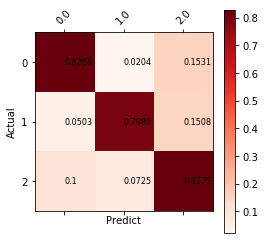

In [64]:
generate_confusion_matrix(xgb_model, x_comb_test, y_comb_test)

In [62]:
import joblib

In [63]:
joblib.dump(xgb_model, 'model/xgboost_on_tansfer_learning_using_comb_data2_2_classes_oversampled.h5') 

['model/xgboost_on_tansfer_learning_using_comb_data2_2_classes_oversampled.h5']

In [82]:
xgb_model = joblib.load('model/xgboost_on_tansfer_learning_using_augmented_lgbtq_nonbinary_data.h5')

In [83]:
eval_xgb_acc(xgb_model, x_test_all, y_test_all)

test accuracy: 0.6479909451046972


In [84]:
eval_xgb_acc(xgb_model, x_nonB_test, y_nonB_test)

test accuracy: 0.6705882352941176


In [85]:
eval_xgb_acc(xgb_model, x_nonLGBTQ_test, y_nonLGBTQ_test_new)

test accuracy: 0.756


In [86]:
eval_xgb_acc(xgb_model, x_lgbtq_test, y_lgbtq_test_new)

test accuracy: 0.46548323471400394


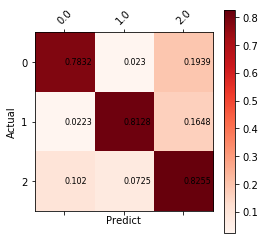

In [48]:
generate_confusion_matrix(xgb_model, x_comb_test, y_comb_test)